FurthVisualizing the innards of the three optimization for adaptive behavior on serial neurogym.

In [1]:
#!/usr/bin/env python
# coding: utf-8
# system
import os
import sys
root = os.getcwd()
sys.path.append(root)
sys.path.append('..')
from pathlib import Path
import json
# tools
import time
import itertools
from collections import defaultdict
# computation
import math
import numpy as np
import random
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
# tasks
import gym
import neurogym as ngym
from neurogym.wrappers import ScheduleEnvs
from neurogym.utils.scheduler import RandomSchedule
# models
# from model_dev import RNN_MD
# from model_dev import serial_RNN_MD as RNN_MD
# from utils import get_full_performance
# visualization
import matplotlib as mpl
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.dpi'] = 100
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm, trange
import seaborn as sns
from utils import get_logs_and_files, convert_train_to_test_idx


In [2]:
data_folder = './../files/paper_data/cluster_neurogym_thalamus_vs_rnn/'
exp_name= 'random_gates_mul'
print('current folder: ', os.getcwd())
filenames = os.listdir(data_folder + exp_name)
testing_log_files = [logfile for logfile in filenames if logfile.__contains__('testing_log')]
training_log_files = [logfile for logfile in filenames if logfile.__contains__('training_log')]
config_files = [logfile for logfile in filenames if logfile.__contains__('config')]

seed = 14
loops = 1.0
task_rule = 1000.0
no_of_tasks = 5
var4  = 1.0


def load_simulation(data_folder, exp_name, seed, var1, var3, var4, no_of_tasks, dataset):
    search_strs=[f'seed{seed}_', f'tasks_{no_of_tasks}_',dataset, f'{var1:3.1f}_{var3:1.1f}_{var4:1.1f}']
    testing_logs, test_files = get_logs_and_files(data_folder, exp_name, file_sig='testing_log', search_strs=search_strs)
    training_logs, train_files = get_logs_and_files(data_folder, exp_name, file_sig='training_log', search_strs=search_strs)
    configs, config_files = get_logs_and_files(data_folder, exp_name, file_sig='config', search_strs=search_strs)
    config_files
    
    if len(training_logs) > 0:
        testing_log = testing_logs[0]
        training_log = training_logs[0]
        config = configs[0]
        assert len(training_logs) == 1, 'more than one training_log found!'
    else:
        print( f'unable to load {search_strs}!')
        testing_log, training_log, config = None, None, None        
    return config,training_log,testing_log

current folder:  /home/ahummos/code/multiplicative/analysis


In [3]:
# Seeds = list(range(3,13))#[6, 7, 8, 10,  14, ]#range(11,15)
# Var1 = [0,1] # train or not LU optim SGD, ADam 
# Var3 = [0., 0.5, 0.8]# gates sparsity LU LR multiplier ,100] # [(x/10) for x in range(1,5, 1)] #gates_std  #, 3.5, 4, 4.5, 5, 5.5, 6, 6.5]
# Var4 = [0.0, 0.1, 0.5, 0.8] # gates std few_)shots [(x/10) for x in range(0,6, 4)] #gates_sparsity  #, 3.5, 4, 4.5, 5, 5.5, 6, 6.5]
# exp_name = 'iclr_testing'
# data_folder = './../files/cluster_iclr_Wz_tests2/'
dataset = 'neurogym'


### Testing for LUs every trial
Seeds = list(range(0,10))#[6, 7, 8, 10,  14, ]#range(11,15)
Var1 = [1] # train or not LU optim SGD, ADam 
Var3 = [100]# gates sparsity LU LR multiplier ,100] # [(x/10) for x in range(1,5, 1)] #gates_std  #, 3.5, 4, 4.5, 5, 5.5, 6, 6.5]
Var4 = [100] # gates std few_)shots [(x/10) for x in range(0,6, 4)] #gates_sparsity  #, 3.5, 4, 4.5, 5, 5.5, 6, 6.5]
exp_name = 'few_shot_testing'
data_folder = './../files/iclr_neurogym_update_every_trial_2LUs/'


# from utils import load_simulation
exps = []
data = defaultdict(list)
no_of_tasks = 5
for var1 in Var1:
    for var3 in Var3:
        for var4 in Var4:
            for seed in Seeds:
                config, training_log, testing_log = load_simulation(data_folder, exp_name, seed, var1, var3, var4, no_of_tasks, dataset)
                if not config is None: # if exp actually loaded and exists.
                    exps.append({'var1': var1, 'var3': var3, 'no_of_tasks': no_of_tasks, 'seed': seed, 'var4': var4})
                    testing_idx = int((15- no_of_tasks) *2) +1
                    data['ttcs'].append(training_log.trials_to_crit[:-testing_idx])
                    data['ttcs40'].append(training_log.trials_to_crit[-testing_idx-20:-testing_idx])
                    # data['ltcs40'].append(training_log.latents_to_crit[-testing_idx-20:-testing_idx])
                    data['latent_updates'].append(training_log.latents_to_crit[:-testing_idx])
                    data['total_compute'].append(np.stack(training_log.latents_to_crit[-testing_idx-20:-testing_idx]) + np.stack(training_log.trials_to_crit[-testing_idx-20:-testing_idx]))
                    data['accuracy'].append(training_log.accuracies[training_log.start_testing_at-500:training_log.start_testing_at])
                    try:
                        data['lu_stamps_acc_improve'].append((training_log.lu_stamps_acc_improve))
                        data['switches'].append(training_log.switch_trialxxbatch[:-testing_idx])
                        data['clock_time'].append(training_log.training_duration)
                    except:
                        print('error: ', exps[-1])
                    # data['total_batches'].append(training_log.stamps[-1])



/tmp/ipykernel_189673/1843855953.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  switch_averages[i] = (np.array(switch_collapse[i]).sum())/ len(switch_collapse[i])
/om2/user/ahummos/anaconda/lib/python3.8/site-packages/numpy/core/_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/tmp/ipykernel_189673/1843855953.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to 

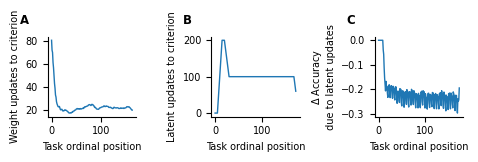

In [6]:
label1 = 'Wz fixed'
label2 = 'Wz learned'
var11 = 0.0
var12 = 1
var3 = 0.5
var4 = 0.0
filter = 5

# label1 = 'Wz Bern'
# label2 = 'Wz Gaus'
var11 = 0.0 # learned
var12 = 1.0
var31 = 0.5 # sparsity
var32 = 0.5
var41 = 0.0 # gaussian std
var42 = 0.0

### Testing for LUs every trial
label1 = '2LUs'
label2 = '2LUs'
var11 = 1.0
var12 = 1
var31 = 100.0
var32 = 100.0
var41 = 100.0
var42 = 100.0

def plot_comparison(label1, label2, var11, var12, var31, var32, var41, var42):
    fig, axes = plt.subplot_mosaic([['A', 'B', 'C']],
                              constrained_layout=False, figsize = [12/2.53, 4/2.53])
    plot_a_second_condition = False
    import matplotlib.transforms as mtransforms
    for label, ax in axes.items():
    # label physical distance to the left and up:
        trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='large', va='bottom', fontfamily='arial',weight='bold')
    linewidth = 1
    filter = 10
    ax = axes['A']
    ttcs = np.stack([data['ttcs'][i]  for i in range(len(data['ttcs'])) if exps[i]['var1'] == var11 and exps[i]['var3'] == var31 and exps[i]['var4'] == var41])
    ax.plot(np.convolve(ttcs.mean(0), np.ones(filter)/filter, 'valid'), label = label1, linewidth  = linewidth)
    ttcs = np.stack([data['ttcs'][i]  for i in range(len(data['ttcs'])) if exps[i]['var1'] == var12 and exps[i]['var3'] == var32 and exps[i]['var4'] == var42])
    if plot_a_second_condition:
        ax.plot(np.convolve(ttcs.mean(0), np.ones(filter)/filter, 'valid'), label = label2, linewidth  = linewidth)
        ax.legend()
# ax.plot(ax.get_xlim(), [0, 0], ':')
    ax.set_ylabel('Weight updates to criterion')
    ax.set_xlabel('Task ordinal position')

    ax = axes['B']
    ttcs = np.stack([data['latent_updates'][i]  for i in range(len(data['latent_updates'])) if exps[i]['var1'] == var11 and exps[i]['var3'] == var31 and exps[i]['var4'] == var41])
    ax.plot(np.convolve(ttcs.mean(0), np.ones(filter)/filter, 'same'), label = label1, color='tab:blue', linewidth  = linewidth)
    ttcs = np.stack([data['latent_updates'][i]  for i in range(len(data['latent_updates'])) if exps[i]['var1'] == var12 and exps[i]['var3'] == var32 and exps[i]['var4'] == var42])
    
    if plot_a_second_condition:
        ax.plot(np.convolve(ttcs.mean(0), np.ones(filter)/filter, 'same'), label = label2, color='tab:orange', linewidth  = linewidth)


    ax.set_ylabel('Latent updates to criterion')
# ax.plot(ax.get_xlim(), [0, 0], ':')
    ax.set_xlabel('Task ordinal position')

    ax = axes['C']
    lu_stamps_acc_improve= [data['lu_stamps_acc_improve'][i]  for i in range(len(data['lu_stamps_acc_improve'])) if exps[i]['var1'] == var11 and exps[i]['var3'] == var31 and exps[i]['var4'] == var41]
    switches = [data['switches'][i]  for i in range(len(data['switches'])) if exps[i]['var1'] == var11 and exps[i]['var3'] == var31 and exps[i]['var4'] == var41]

    def extract_improv_averages(lu_stamps_acc_improve, switches):
        switch_master =[]
        for lu_improv, switches in zip(lu_stamps_acc_improve, switches):
            switch_local = [[] for _ in range(len(switches))]
            for switch_i,switch in enumerate(switches):
                if len(lu_improv)> 0:
                    indexes = np.array(lu_improv)[:,0]
                    improvs = np.array(lu_improv)[:,1]
                    bin_entries = np.where(indexes == switch , True, False)
                    if len(improvs[bin_entries ]) > 0: switch_local[switch_i].append(improvs[bin_entries ])
            switch_master.append(switch_local)

        switch_collapse = [[0] for _ in range(len(switches))]
        switch_averages = np.zeros(len(switches))
        for i in range(len(switch_collapse)):
            [switch_collapse[i].extend(switch_m[i]) for switch_m in switch_master if switch_m[i] !=[0]]
    # print(np.array(switch_collapse[i]))
            switch_averages[i] = (np.array(switch_collapse[i]).sum())/ len(switch_collapse[i])
        averages = [np.mean(ss) for ss in switch_collapse]
        return averages

    averages = extract_improv_averages(lu_stamps_acc_improve, switches)

    ax.plot(np.convolve(np.array(averages), np.ones(4)/4)[:-2], label=label1, color='tab:blue', linewidth  = linewidth)

    lu_stamps_acc_improve= [data['lu_stamps_acc_improve'][i]  for i in range(len(data['lu_stamps_acc_improve'])) if exps[i]['var1'] == var12 and exps[i]['var3'] == var32 and exps[i]['var4'] == var42]
    switches = [data['switches'][i]  for i in range(len(data['switches'])) if exps[i]['var1'] == var11 and exps[i]['var3'] == var32 and exps[i]['var4'] == var42]
    averages = extract_improv_averages(lu_stamps_acc_improve, switches)
    if plot_a_second_condition:
        ax.plot(np.convolve(np.array(averages), np.ones(4)/4)[:-2], label=label2, color='tab:orange', linewidth  = linewidth)
        ax.legend()
    ax.set_ylabel(''r'$\Delta$ Accuracy'+ '\n'+ ' due to latent updates ')
    ax.set_xlabel('Task ordinal position')
    clock_times1= [data['clock_time'][i]  for i in range(len(data['clock_time'])) if exps[i]['var1'] == var11 and exps[i]['var3'] == var31 and exps[i]['var4'] == var41]
    clock_times2= [data['clock_time'][i]  for i in range(len(data['clock_time'])) if exps[i]['var1'] == var12 and exps[i]['var3'] == var32 and exps[i]['var4'] == var42]
    # ax.text(10,0.6,  f'{np.stack(clock_times1).mean():2.2f}', color='tab:blue')
    # ax.text(100,0.6,  f'{np.stack(clock_times2).mean():2.2f}', color='tab:orange')
    fig.tight_layout()

plot_comparison(label1, label2, var11, var12, var31, var32, var41, var42)
plt.savefig('./files/pdfs/quantifyingThalamus_WULU.pdf', dpi=300)

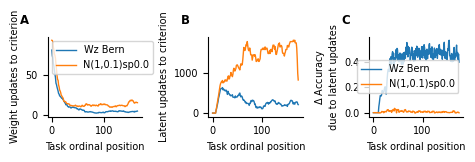

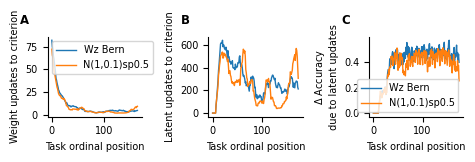

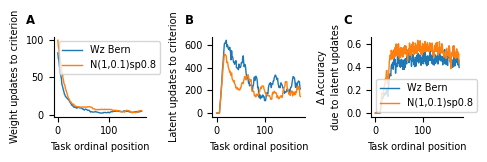

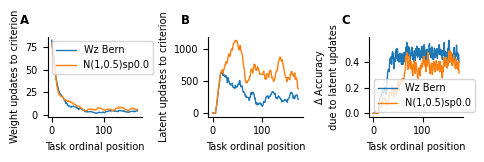

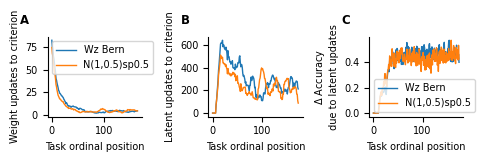

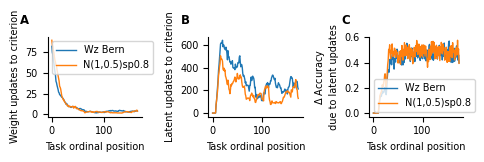

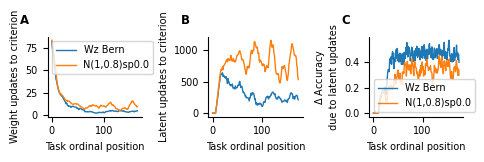

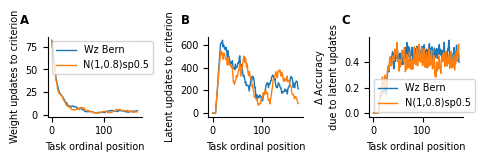

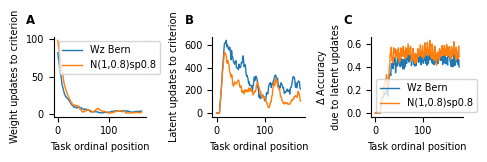

In [48]:
Var1 = [0,1] # train or not LU optim SGD, ADam 
Var3 = [0., 0.5, 0.8]# gates sparsity LU LR multiplier ,100] # [(x/10) for x in range(1,5, 1)] #gates_std  #, 3.5, 4, 4.5, 5, 5.5, 6, 6.5]
Var4 = [0.0, 0.1, 0.5, 0.8] #+ [1., 1.5, 2.] # gates std few_)shots [(x/10) for x in range(0,6, 4)] #gates_sparsity  #, 3.5, 4, 4.5, 5, 5.5, 6, 6.5]

label1 = 'Wz Bern'
label2 = 'N(1,'
var11 = 0.0 # learned
var12 = 0.0
var31 = 0.5 # sparsity
var32 = 0.0
var41 = 0.0 # gaussian std
var42 = 0.8
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
mpl.rcParams['figure.dpi'] = 100
for var42 in Var4[1:]:
    for var32 in Var3:
        plot_comparison(label1, f'{label2}{var42})sp{var32}', var11, var12, var31, var32, var41, var42)

/tmp/ipykernel_27928/1358375779.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  switch_averages[i] = (np.array(switch_collapse[i]).sum())/ len(switch_collapse[i])
/om2/user/ahummos/anaconda/lib/python3.8/site-packages/numpy/core/_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/tmp/ipykernel_27928/1358375779.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do

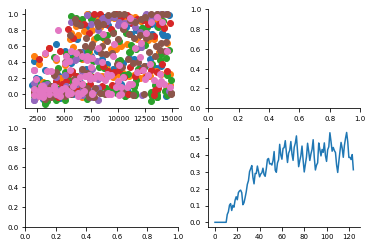

In [53]:
# Another analysis of LU improvements by binning the data. 
# data['lu_stamps_acc_improve']
fig, axes = plt.subplots(2,2,)

for lu_improv in data['lu_stamps_acc_improve']:
    if len(lu_improv)> 0:
        axes[0,0].scatter(np.array(lu_improv)[:,0], np.array(lu_improv)[:,1])

min_step = 2000
max_step = 14000
whole_N = max_step-min_step
bin_width = whole_N // 50
no_of_bins = whole_N//bin_width
bin_averages = np.zeros(no_of_bins)
bin_dumps = [[] for _ in range(no_of_bins)]
for bin_i in range(no_of_bins):
    bin_begin = bin_i * bin_width
    bin_end = (bin_i+1) * bin_width
    for lu_improv in data['lu_stamps_acc_improve']:
        if len(lu_improv)> 0:
            indexes = np.array(lu_improv)[:,0]
            improvs = np.array(lu_improv)[:,1]
            # matching_indexes = indexes[indexes > bin_begin]
            # matching_indexes = matching_indexes[matching_indexes < bin_end]
            # bin_averages[bin_i] = improvs[indexes > bin_begin  ].mean()
            bin_entries = np.where((indexes > bin_begin) & (indexes < bin_end), True, False)
            bin_averages[bin_i] += improvs[bin_entries ].sum()/(bin_entries.sum()+1)
            if len(improvs[bin_entries ]) > 0: bin_dumps[bin_i].append(improvs[bin_entries ])
axes[1,0].plot(bin_averages)

axes[1,1].plot( ([np.hstack(bin).mean() if len(bin)>0 else 0 for bin in bin_dumps ]))
axes[1,1].set_xlabel('accuracy improved after LU')
#should plots against trial switches
axes[0,1].plot( ([np.hstack(bin).mean() if len(bin)>0 else 0 for bin in bin_dumps ]))


In [68]:
def get_mean_sem(data):
    sem = np.std(data, ddof=1) / np.sqrt(np.size(data))
    mean = np.mean(data)
    # python
    # return(f'{mean:1.2f} ' + (u"\u00B1")+f' {sem:1.2f}')
    #latex
    return(f'{mean:1.2f} ' + '$\\pm$' + f' {sem:1.2f}')


In [69]:
[]

print('RNN', '&', get_mean_sem(compute_weight_updates), '&', get_mean_sem(weight_ttcs_means), '&', get_mean_sem(accs_weight_updates),'\\\\')
print('Thalamus', '&', get_mean_sem(compute_weight_updates), '&', get_mean_sem(weight_ttcs_means), '&', get_mean_sem(accs_weight_updates),'\\\\')



RNN & 23.73 $\pm$ 1.21 & 23.73 $\pm$ 1.21 & 0.91 $\pm$ 0.00 \\
Thalamus & 23.73 $\pm$ 1.21 & 23.73 $\pm$ 1.21 & 0.91 $\pm$ 0.00 \\


In [70]:
Labels = [ 'No of Weight updates','Avg transition accuracy', 'Weight+latent updates (Compute)']
RNN_data = [weight_ttcs_means, accs_weight_updates, compute_weight_updates]
Thalamus_data = [latent_ttcs_means, accs_Thalamus, compute_Thalamus]

print('Model',    *[' & ' + label for label in Labels], '\\\\')
print('RNN',      *[' & ' + get_mean_sem(rd) for rd in RNN_data] ,'\\\\')
print('Thalamus', *[' & ' + get_mean_sem(rd) for rd in Thalamus_data] ,'\\\\')
    


Model  & No of Weight updates  & Avg transition accuracy  & Weight+latent updates (Compute) \\
RNN  & 23.73 $\pm$ 1.21  & 0.91 $\pm$ 0.00  & 23.73 $\pm$ 1.21 \\
Thalamus  & 3.64 $\pm$ 0.50  & 0.96 $\pm$ 0.00  & 271.56 $\pm$ 55.28 \\


In [11]:
no_of_tasks=5
for seed in range(15):
    try:
        config, training_log, testing_log = load_simulation(data_folder, exp_name, seed, var1, var3, var4, no_of_tasks, dataset)
        print('seed: ', seed)
        plot_long_term_cluster_discovery(config, training_log, testing_log)
    except:
        pass

In [4]:

data_folder = './../files/paper_data/cluster_neurogym_tasks10_to_convergence2/'
dataset = 'neurogym'
exp_name= 'random_gates_mul'
# from utils import load_simulation
exps = []
data = defaultdict(list)
no_of_tasks=10
for var1 in [0.0, 1.0 ]:  # 1.0 for using latent updates(Thalamus)  0.0 for WU 
    for var3 in [1000.0]:
        for var4 in [0.0, 1.0]: ## 0.0 for using task IDs  1.0 for THalamus
            for seed in range(1,10):
                if var1 == 1.0 and var4== 0.0: continue
                config, training_log, testing_log = load_simulation(data_folder, exp_name, seed, var1, var3, var4, no_of_tasks, dataset)
                if not config is None: # if exp actually loaded and exists.
                    exps.append({'var1': var1, 'var3': var3, 'no_of_tasks': no_of_tasks, 'seed': seed, 'var4': var4})
                    end_accs = np.array(training_log.accuracies)[np.array(training_log.switch_trialxxbatch[-10:])-1]
                    end_accs_recorded = np.array(training_log.testing_accuracies)
                    data['end_accs'].append(end_accs)
                    # data['end_accs_recorded'].append(end_accs_recorded)
                    # print('accuracies at the end of each task', end_accs)
                    # print('solved ratio: ', np.mean(end_accs>= 0.7))
Thalamus = [1.0, 1.0]
CAI = [0.0, 0.0]
RNN = [0.0, 1.0]
tags = [Thalamus, CAI, RNN]
labels = ['Thalamus', 'CAI', 'RNN']
for p in range(3):
    print(labels[p], ':\n')
    # data = [dat for dat in data['end_accs']]
    dat = [data['end_accs'][i]  for i in range(len(data['end_accs'])) if exps[i]['var1'] == tags[p][0] and exps[i]['var4'] == tags[p][1]]
    dat_recorded = [data['end_accs_recorded'][i]  for i in range(len(data['end_accs_recorded'])) if exps[i]['var1'] == tags[p][0] and exps[i]['var4'] == tags[p][1]]
    # dat = [data['end_accs'][i]  for i in range(len(data['end_accs'])) ]
    solved_thresh_accuracy = 0.8
    print('Mean ratio solved: ', np.mean(np.array(dat)>=solved_thresh_accuracy), '+-', np.std(np.array(dat)>=solved_thresh_accuracy)/np.sqrt(10))
    print('Mean average: ', np.mean(np.array(dat)), '+-', np.std(np.array(dat))/np.sqrt(10))
# fig, axes = plt.subplots(2,3, sharey=False)
    # print('Mean ratio solved_recorded: ', np.mean(np.hstack(dat_recorded)>=0.7), '+-', np.std(np.hstack(dat_recorded)>=0.7)/np.sqrt(10))
    # print('Mean average_recorded: ', np.mean(np.hstack(dat_recorded)), '+-', np.std(np.hstack(dat_recorded))/np.sqrt(10))

Thalamus :

Mean ratio solved:  0.2777777777777778 +- 0.14163943093313291
Mean average:  0.4912222 +- 0.11019460867911161
CAI :

Mean ratio solved:  0.2 +- 0.12649110640673517
Mean average:  0.46977776 +- 0.10691530280623167
RNN :

Mean ratio solved:  0.2111111111111111 +- 0.12905162140652987
Mean average:  0.43555558 +- 0.11053416699467443


Below is just some random stuff






In [88]:
config, training_log, testing_log = load_simulation(data_folder, exp_name, 2, var1, var3, var4, no_of_tasks, dataset)
real_testing_idx = testing_idx-1
print(len(training_log.trials_to_crit[-real_testing_idx:]))
print((training_log.trials_to_crit[-real_testing_idx:]))
print((training_log.latents_to_crit[-real_testing_idx:]))


20
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[9, 199, 199, 8, 199, 199, 199, 199, 199, 199, 10, 199, 199, 7, 199, 199, 199, 199, 199, 199]


In [107]:
cum_idz = np.cumsum(training_log.latents_to_crit[-real_testing_idx:])
np.array(training_log.accuracies)[cum_idz[-1]-5: cum_idz[-1]+5]

array([0.57      , 0.57      , 0.45999998, 0.65      , 0.63      ,
       0.63      , 0.69      , 0.68      , 0.7       , 0.65      ],
      dtype=float32)

In [2]:
def plot_long_term_cluster_discovery( config, training_log, testing_log,end):
    # if len(training_log.bu_context_ids) > 0: context_ids =  training_log.bu_context_ids
    if len(training_log.td_context_ids) > 0: context_ids =  training_log.td_context_ids
    elif len(training_log.md_context_ids) > 0: context_ids =  training_log.md_context_ids
    else: 
        policy_context_id = np.ones([1,config.md_size])/config.md_size
        context_ids = [policy_context_id.repeat(config.batch_size, 0)] * training_log.stamps[-1]


    # x0, x1 = 0, training_log.stamps[-1]
    x0, x1 = 0, end#training_log.start_testing_at
    no_of_values = len(config.tasks)
    norm = mpl.colors.Normalize(vmin=min([0,no_of_values]), vmax=max([0,no_of_values]))
    cmap_obj = mpl.cm.get_cmap('Set1') # tab20b tab20
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap_obj)

    switches=  training_log.switch_trialxxbatch[:] 
    # switches=  training_log.switch_trialxxbatch[1:] # earlier on I must have added zero as a switch trial 

    fig, axes = plt.subplots(3,1, figsize=[16/2.53,3], sharex = False)

    ax = axes[0]
    # ax.set_position(mpl.transforms.Bbox([[0.125, 0.715], [.747, 0.880]]))
    ax.plot(np.array(training_log.stamps)[x0:x1], np.array(training_log.accuracies)[x0:x1], linewidth=1)
    for ri in range(len(switches)-1):
        ax.axvspan(training_log.switch_trialxxbatch[ri], training_log.switch_trialxxbatch[ri]+1, color =cmap.to_rgba(training_log.switch_task_id[ri]) , alpha=0.5)
        id = training_log.switch_task_id[ri]
        task_name = config.human_task_names[id]
        if training_log.switch_trialxxbatch[ri] < x1:
            ax.text(training_log.switch_trialxxbatch[ri], 1.0 + np.random.uniform(-0.1, 0.25), task_name, color= cmap.to_rgba(id) , fontsize=7)
    ax.set_ylabel('current task accuracy')
    ax.set_xlim([x0, x1])
    # print('axis 0 position: ',ax.get_position())
    
    ax = axes[1] # context ids
    md = np.stack([m[0] for m in context_ids])
    # print(fig.get_axes())
    im = sns.heatmap(md.T, cmap='Reds', ax = ax)#, vmax=md.max()/3)
    # print(fig.get_axes())
    # print('colorbar pos:', fig.get_axes()[-1].get_position())
    fig.get_axes()[-1].set_position(mpl.transforms.Bbox([[0.9037,0.39],[.90785, 0.600]]))
    # ax.get_shared_x_axes().join(ax, axes[0])
    ax.set_xticks(axes[0].get_xticks()[:-1])
    ax.set_xticklabels(axes[0].get_xticklabels()[:-1], rotation=0)
    # ax.set_xlabel('Batches (100 trials)')
    ax.set_ylabel('Latent z vector')
    ax.set_position(mpl.transforms.Bbox([[0.125,0.39],[.902, 0.613]]))
    # ax.set_position(mpl.transforms.Bbox([[0.125,0.52],[.99, 0.683]]))
    # print(ax.get_position())
    ax.set_xlim([x0, x1])

    ax = axes[2] # mean_bu
    # ax.plot(np.array(training_log.stamps)[x0:x1], np.array(training_log.accuracies)[x0:x1])
    # ax.set_xlim([x0, x1])
    # ax.set_ylabel('current task accuracy')
    # ax.set_xlabel('Batches (100 trials)')
    # # print(ax.get_position())
    # # =0.125, y0=0.32195652173913036, x1=0.9, y1=0.4860869565217391
    # ax.set_position(mpl.transforms.Bbox([[0.125,0.32],[.9, 0.45]]))
    # ax.plot(training_log.trials_to_crit, label = 'trials to crit')
    ax.plot(training_log.switch_trialxxbatch, training_log.trials_to_crit, label = 'Weight updates', color='tab:blue', linewidth=1)
    ax.plot(training_log.switch_trialxxbatch,training_log.trials_to_crit, 'o', markersize=4, color='tab:blue')
    filter=10
    filtered_mean = np.convolve(np.array(training_log.trials_to_crit), np.ones(filter)/filter, 'same')
    try:
        ax.plot(training_log.switch_trialxxbatch,filtered_mean, label=f'Weight updates avg', color='tab:orange',)
        mpl.rcParams['axes.spines.right'] = True
        ax2 =  ax.twinx()
        ax2.set_ylabel('Latent updates', color= 'tab:red') 
        ax2.plot(training_log.switch_trialxxbatch,np.clip(np.array(training_log.latents_to_crit),0, a_max=1000), 'x',markersize=4,color='tab:red', label = 'Latent updates')
        # ax2.plot([la[0]for la in training_log.lu_stamps_acc_improve], np.stack([la[1]for la in training_log.lu_stamps_acc_improve])*1000, '.', color='tab:green')
        ax2.tick_params(axis='y', color='tab:red', labelcolor='tab:red')
        ax2.legend(loc="lower right")
        mpl.rcParams['axes.spines.right'] = False
    except:
        pass
    ax.set_ylabel('Weight updates to criterion')
    ax.set_xlabel('Trials')
    ax.set_xlim([x0, x1])
    ax.set_ylim(0, 100)#filtered_mean.max()*1.5)
    if hasattr(training_log, 'converged_detected_at'):
        ax.axvline(training_log.converged_detected_at, color='tab:green', alpha=0.5, linewidth=2, label='Converged')
    ax.legend()
    # print(ax.get_position())
    ax.set_position(mpl.transforms.Bbox([[0.125,0.125],[.90, 0.33]]))
    identifiers = 9
    # plt.savefig(f'./files/candidates/5/thalanet_{seed}_{no_of_tasks}.pdf', dpi=300)
# plot_long_term_cluster_discovery(config, training_log, testing_log)

In [112]:
print(cum_idz[-1] + training_log.start_testing_at)
print(len(training_log.accuracies))

18218
18238


In [ ]:
def plot_credit_assignment_inference( config, training_log, testing_log):
    if len(training_log.bu_context_ids) > 0: context_ids =  training_log.bu_context_ids
    elif len(training_log.td_context_ids) > 0: context_ids =  training_log.td_context_ids
    else: 
        # len(training_log.md_context_ids) > 0: 
        policy_context_id = np.ones([1,config.md_size])/config.md_size
        context_ids = [policy_context_id.repeat(config.batch_size, 0)] * training_log.stamps[-1]

    
    mg = np.stack(np.stack([bci.mean(0) for bci in context_ids]))
    # mg = mg.mean(1) #(7957, 15) # average across batch

    x0, x1 = 0, training_log.stamps[-1]
    no_of_values = len(config.tasks)
    norm = mpl.colors.Normalize(vmin=min([0,no_of_values]), vmax=max([0,no_of_values]))
    cmap_obj = mpl.cm.get_cmap('Set1') # tab20b tab20
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap_obj)

    switches=  training_log.switch_trialxxbatch[:] 
    # switches=  training_log.switch_trialxxbatch[1:] # earlier on I must have added zero as a switch trial 

    fig, axes = plt.subplots(4,1, figsize=[12,6], sharex = True)

    ax = axes[0]
    print(ax.get_position())
    ax.set_position(matplotlib.transforms.Bbox([[0.125, 0.715], [.747, 0.880]]))

    ax.plot(np.array(training_log.stamps)[x0:x1], np.array(training_log.accuracies)[x0:x1])
    for ri in range(len(switches)-1):
        ax.axvspan(training_log.switch_trialxxbatch[ri], training_log.switch_trialxxbatch[ri]+1, color =cmap.to_rgba(training_log.switch_task_id[ri]) , alpha=0.5)
        id = training_log.switch_task_id[ri]
        task_name = config.human_task_names[id]
        ax.text(training_log.switch_trialxxbatch[ri], 1.0 + np.random.uniform(-0.1, 0.25), task_name, color= cmap.to_rgba(id) , fontsize=10)
    ax.set_ylabel('current task accuracy')
    ax.set_xticks(list(range(0, x1, 200)))
    ax.set_xticklabels([str(i) for i in list(range(0, x1, 200))])
    # ax.set_xlim([x0, x1])
    # for ri in range(len(training_log.switch_trialxxbatch)-1):
    #     ax.axvspan(training_log.switch_trialxxbatch[ri], training_log.switch_trialxxbatch[ri+1], color =cmap.to_rgba(training_log.switch_task_id[ri]) , alpha=0.2)
    ax = axes[1]
    t = 0
    d = training_log.stamps[-1]
    average_acc =[]
    taa = []
    for logi in range(config.no_of_tasks):
        taa.append([test_acc[logi] for test_acc in testing_log.accuracies])
    average_acc.append(np.stack(taa))

    testing_t = convert_train_to_test_idx(training_log, testing_log, t)
    testing_e =convert_train_to_test_idx(training_log, testing_log, t+d)
    ax.plot(testing_log.stamps[testing_t:testing_e], average_acc[0].mean(0)[testing_t:testing_e])
    ax.axvspan(0, d, color='tab:blue', alpha=0.2)
    ax.set_ylim([0,1])
    ax.set_ylabel('all tasks with Rule accuracy')
    # ax.set_title('With task rule input provided')
    # print(ax.get_position())
    ax.set_position(matplotlib.transforms.Bbox([[0.125, 0.519], [.747, 0.683]]))    

    ax = axes[2]
    mtd = mg.squeeze()# np.stack(context_ids)
    # mtd = tdci.mean(1) # (7729, 15)
    im = sns.heatmap(mtd.T, ax = ax)
    ax.set_xlim([x0, x1])
    ax.set_ylabel('md activity')
    # ax.colorbar()
    # plt.colorbar(im) #, ax=ax.ravel().tolist())


    ax.set_xlim([x0, x1])

    # ax.set_ylim([0,1])
    for ri in range(len(switches)-1):
        # print(ri)
        ax.scatter(switches[ri], (training_log.switch_task_id[ri]+0.5), color =cmap.to_rgba(training_log.switch_task_id[ri]) ,  linewidth=4, )#alpha=0.2)
        ax.axvspan(training_log.switch_trialxxbatch[ri], training_log.switch_trialxxbatch[ri]+1, color =cmap.to_rgba(training_log.switch_task_id[ri]) , alpha=0.9)

    ax = axes[3]
    ax = sns.heatmap(mg.T, cmap='Reds', ax = ax, vmax=mg.max()/3)
    ax.set_xticks(list(range(0, x1, 200)))
    ax.set_xticklabels([str(i) for i in list(range(0, x1, 200))])
    ax.set_xlim([x0, x1])
    ax.set_ylabel('MD grads')
    ax.set_xlabel('Trials (100)')
    # plt.colorbar(ax)

    # sample_rate = 1
    # hm = sns.heatmap(mg.T, cmap='Reds', ax = ax)
    # # ax.set_yticklabels([str(i) for i in labels])
    # ax.set_ylabel('MD neuron idx', fontsize=8)
    # ax.set_xticks(list(range(0, x1, 200)))
    # ax.set_xticklabels([str(i) for i in list(range(0, x1, 200))])
    # # _=ax.set_xlabel('Trial (1000)', fontsize=8)
    # ax.set_title('MD grads')

    try:
        plt.savefig('./files/'+ config.exp_name+f'/CAI_summary_{config.exp_signature}_bottom_up_optimizing.jpg', dpi=200)
    except:
        # plt.savefig('./../files/'+ config.exp_name+f'/CAI_summary_{config.exp_signature}_bottom_up_optimizing.jpg', dpi=200)
        plt.savefig('./../files/'+ config.exp_name+f'/CAI_summary_{config.exp_signature}_bu_optimizing_many_batches.jpg', dpi=300)
        # plt.savefig('./../files/'+ config.exp_name+f'/CAI_summary_{config.exp_signature}_policy_optimizing.jpg', dpi=200)
plot_credit_assignment_inference(config, training_log, testing_log)

NameError: name 'config' is not defined